#### imports

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution  
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
from matplotlib.patches import Patch
import matplotlib.ticker as ticker



In [2]:
### reading data including individual tumour growth rates
df_all = pd.read_csv("clean_erlotinib.csv") # to see markers etc
total_tumors_df = pd.read_csv("total_tumors.csv")
single_tumors_df = pd.read_csv("single_tumors.csv")
total_tumors_df.head()
no_first_point_df = pd.read_csv("no_first_point.csv")

total_tumors_df.head()

,ID,days,Sum_tumor_lengths,Sum_tumor_volume,Dose_mg,ctDNA_copies_ml,dose_proportion,Sum_tumor_vol_cm
0,A1002,0,58.7,43559.570202,0.0,0.0,0.0,43.559570
1,A1002,62,30.3,5243.630727,150.0,0.0,1.0,5.243631
2,A1002,110,24.1,4106.008715,150.0,0.0,1.0,4.106009
3,A1002,152,26.0,4417.875141,150.0,0.0,1.0,4.417875
4,A1002,187,26.0,4417.875141,150.0,0.0,1.0,4.417875


#### Functions

##### Logistic functions

In [3]:
# Logistic population model
def system_ode_logistic(time, populations, params, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #death rate due to medication
    C = 1 # drug concentration, if

    if kill_rate == 'linear':
        dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - lam*C) # linear kill rate
    elif kill_rate == 'NS':
        dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax))*(1-lam*C) # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")

    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function for logistic population model
    
def cost_func_logistic(params, time, data, kill_rate='linear'):
    initial_populations = params[3:]
    tspan = [time[0], time[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:3], kill_rate))
    
    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   

##### Gompertzian functions


In [4]:
# Gompertzian population model
def system_ode_gompertzian(time, populations, params, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #death rate due to medication
    C = 1 # drug concentration
    epsilon = 1e-6

    if kill_rate == 'linear':
        dSpop_dt = Spop*(r* np.log(kmax/(Spop+Rpop + epsilon))-lam*C) # linear kill rate 
 # linear kill rate
    elif kill_rate == 'NS':
            dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*C)*Spop 
 # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")
    
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop

    return [dSpop_dt, dRpop_dt]

# Cost function for gompertzian population model
   
def cost_func_gompertzian(params, time, data, kill_rate='linear'):
    initial_populations = params[3:]
    tspan = [time[0], time[-1]]
    
    pred_data = solve_ivp(system_ode_gompertzian, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:3], kill_rate))
    
    if pred_data.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        #ean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        #delta = 100
       # huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
       # mean_abs_error = 1e30
       #huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   

##### von Bertalanffy 

In [5]:
##### von Bertalanffy population model 
def system_ode_vonBertalanffy(time, populations, params, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    a = params[1] # exponent 1 - often 2/3, in general VB model, a is a parameter
    Beta = params[2] # natural death rate
    lam = params[3] #death rate due to medication
    C = 1 # drug concentration
    epsilon = 1e-6

    if kill_rate == 'linear':
        dSpop_dt = Spop*(r*(Spop+Rpop)**a-Beta*(Spop+Rpop)) -lam*C # linear kill rate 
 # linear kill rate
    elif kill_rate == 'NS':
            dSpop_dt = Spop*(r*(Spop+Rpop)**a-Beta*(Spop+Rpop)) * (1-lam*C)
 # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")
    
    dRpop_dt = Rpop*(r*(Spop+Rpop)**a - Beta*(Spop+Rpop))

    return [dSpop_dt, dRpop_dt]

# Cost function for vb population model
   
def cost_func_vb(params, time, data, kill_rate='linear'):
    initial_populations = params[4:]
    tspan = [time[0], time[-1]]
    
    pred_data = solve_ivp(system_ode_gompertzian, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:4], kill_rate))
    
    if pred_data.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        #ean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        #delta = 100
       # huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
       # mean_abs_error = 1e30
       #huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   

## Constant medication - different kill rates

### Logistic - basic linear kill 

In [6]:
##### basic logistic, linear kill rate
#### use total tumors df
df = total_tumors_df
unique_IDs = df.ID.unique()
md_constant_basic_log_linear = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-4, 5e-1), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-1, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters
    optimal_params = opt_result_log.x
    pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
                              t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data_log.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_constant_basic_log_linear[id] = optimal_params.tolist() + [opt_result_log.fun, aic, r_squared]


Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 4.78215
differential_evolution step 2: f(x)= 4.78215
differential_evolution step 3: f(x)= 4.78215
differential_evolution step 4: f(x)= 4.02548
differential_evolution step 5: f(x)= 4.02548
differential_evolution step 6: f(x)= 4.02548
differential_evolution step 7: f(x)= 4.02548
differential_evolution step 8: f(x)= 4.02548
differential_evolution step 9: f(x)= 4.02548
differential_evolution step 10: f(x)= 4.02548
differential_evolution step 11: f(x)= 3.92642
differential_evolution step 12: f(x)= 3.92642
differential_evolution step 13: f(x)= 3.92642
differential_evolution step 14: f(x)= 3.92642
differential_evolution step 15: f(x)= 3.92498
differential_evolution step 16: f(x)= 3.92498
differential_evolution step 17: f(x)= 3.92498
differential_evolution step 18: f(x)= 3.92498
differential_evolution step 19: f(x)= 3.92498
differential_evolution step 20: f(x)= 3.92498
differential_evolution step 21: f(x)

In [7]:
df_log_linear_no_comp = pd.DataFrame.from_dict(md_constant_basic_log_linear, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_log_linear_no_comp 

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared
A1002,0.017741,433.450624,0.044836,43.335750,0.000083,3.461396,49.733507,0.906275
A1004,0.000100,28.234569,0.039889,16.719599,2.097014,0.002551,-49.714336,1.000000
A1006,0.000840,257.331365,0.040795,54.403086,2.118169,0.136934,-21.812069,0.999940
A1007,0.003466,59.831644,0.015752,31.843226,7.960254,2.299039,31.644770,0.864935
A1008,0.001467,323.048073,0.024614,34.058299,4.426607,0.897139,7.394934,0.988968
A1009,0.010603,85.677378,0.032263,53.057401,3.811284,1.999621,18.315491,0.983149
A1011,0.000100,75.483440,0.025056,12.279910,0.000010,0.533092,2.451259,0.985436
A1012,0.002122,75.373091,0.012770,40.198982,10.049745,4.874279,38.511501,0.773420
A1013,0.000100,96.016330,0.050472,46.573972,7.300799,0.406228,-2.611771,0.999360
A1014,0.004416,8.431021,0.030914,0.843990,0.002952,0.045664,-101.111630,0.951276


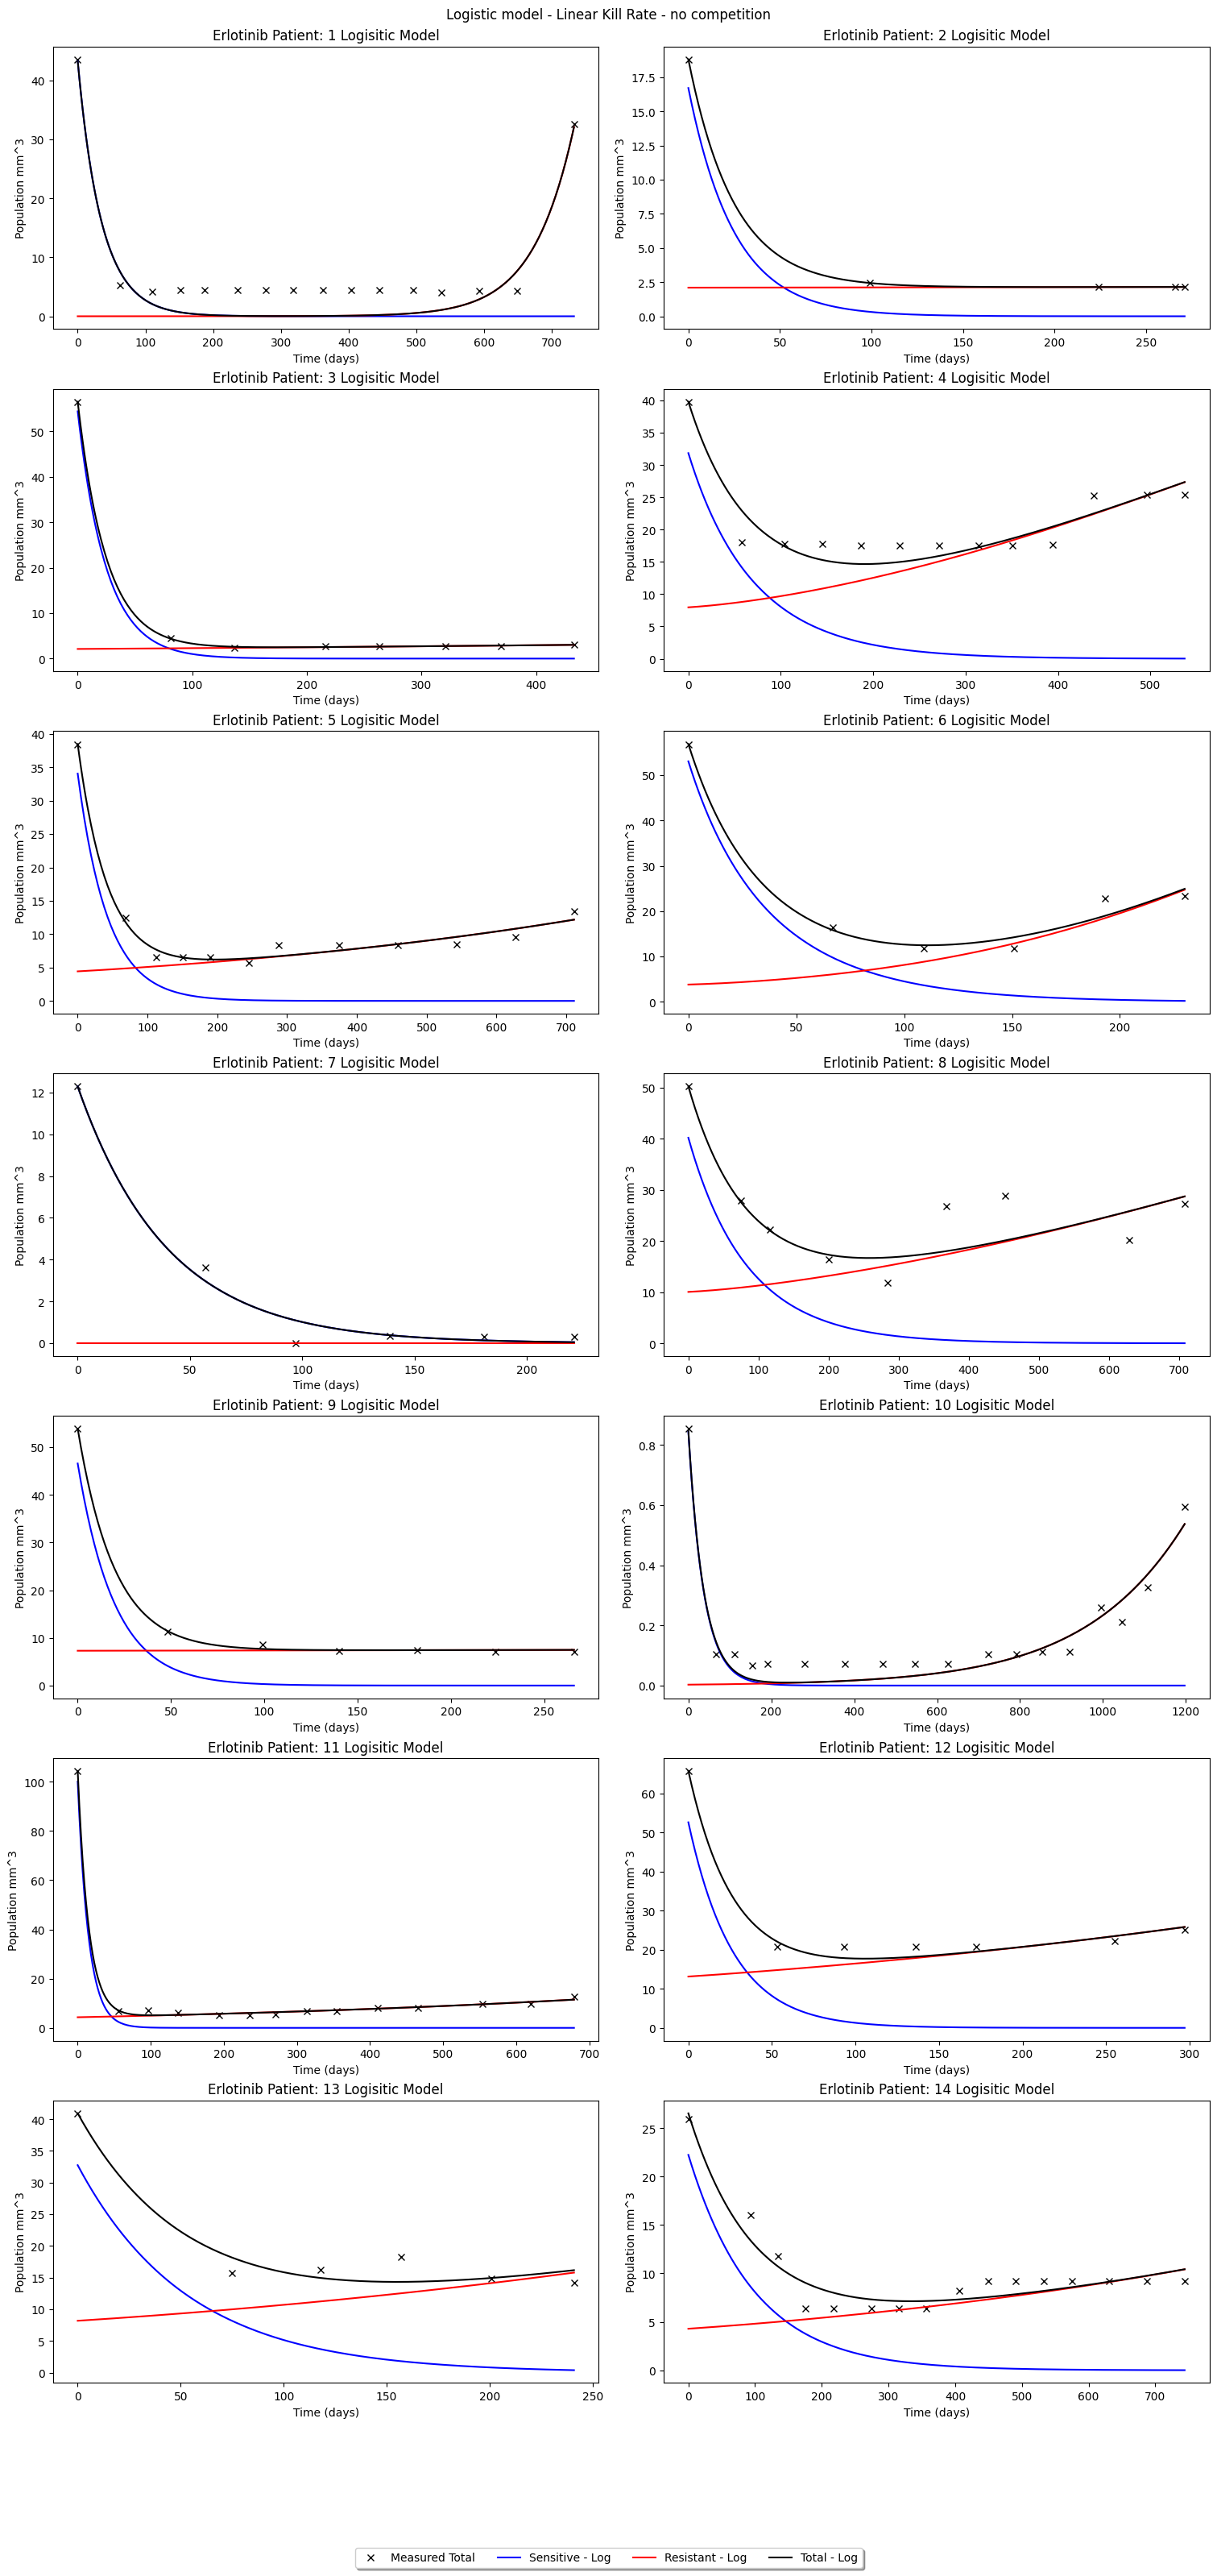

In [8]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = md_constant_basic_log_linear[id]
    init_populations_log = optimal_params_log[3:-3]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logisitic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model - Linear Kill Rate - no competition')  
plt.show()

#### Logistic - basic - NS kill

In [9]:
##### basic logistic, NS kill rate
#### use total tumors df
df = total_tumors_df
unique_IDs = df.ID.unique()
md_const_log_ns = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'NS' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-4, 5e-1), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(1e-4, 5e-2), (1.5*max_value, 10*max_value), 
                  (0.1,50),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters
    optimal_params = opt_result_log.x
    pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
                              t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data_log.y, axis=0)

        # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_const_log_ns[id] = optimal_params.tolist() + [opt_result_log.fun, aic, r_squared]
    # # store the optimal parameters and the cost function value (last entry in list)
    # master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 5.10206
differential_evolution step 2: f(x)= 4.37771
differential_evolution step 3: f(x)= 4.37771
differential_evolution step 4: f(x)= 4.37771
differential_evolution step 5: f(x)= 4.37771
differential_evolution step 6: f(x)= 4.37771
differential_evolution step 7: f(x)= 4.37771
differential_evolution step 8: f(x)= 4.18944
differential_evolution step 9: f(x)= 4.18548
differential_evolution step 10: f(x)= 4.07259
differential_evolution step 11: f(x)= 4.07259
differential_evolution step 12: f(x)= 4.07259
differential_evolution step 13: f(x)= 4.07259
differential_evolution step 14: f(x)= 4.07259
differential_evolution step 15: f(x)= 4.07259
differential_evolution step 16: f(x)= 4.07259
differential_evolution step 17: f(x)= 4.07259
differential_evolution step 18: f(x)= 4.07259
differential_evolution step 19: f(x)= 4.07259
differential_evolution step 20: f(x)= 4.07259
differential_evolution step 21: f(x)

In [10]:
df_log_ns_no_comp = pd.DataFrame.from_dict(md_const_log_ns, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0',
                                              'rmse','aic','r_squared'])

df_log_ns_no_comp 

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared
A1002,0.016786,424.377740,2.833973,43.286336,0.000166,3.483898,49.940857,0.905053
A1004,0.000742,187.441134,49.992709,17.036239,1.780180,0.023817,-27.373585,0.999987
A1006,0.000968,124.543172,49.953685,54.462939,2.063538,0.126696,-23.055448,0.999949
A1007,0.002453,396.034242,7.190185,31.849072,7.959661,2.440847,33.200970,0.847759
A1008,0.001546,57.695219,25.912007,33.627096,4.813834,0.840925,5.841925,0.990307
A1009,0.009665,85.082968,5.360333,52.091792,4.666335,1.881367,17.583981,0.985083
A1011,0.024449,18.434866,2.601652,12.279910,0.002974,0.370155,-1.926001,0.992978
A1012,0.001736,156.799192,9.763922,40.296074,10.049745,4.912999,38.653923,0.769806
A1013,0.000984,530.138703,49.967338,47.744718,6.135412,0.661329,4.210944,0.998305
A1014,0.004387,8.278804,7.478618,0.841185,0.003052,0.046017,-100.834569,0.950520


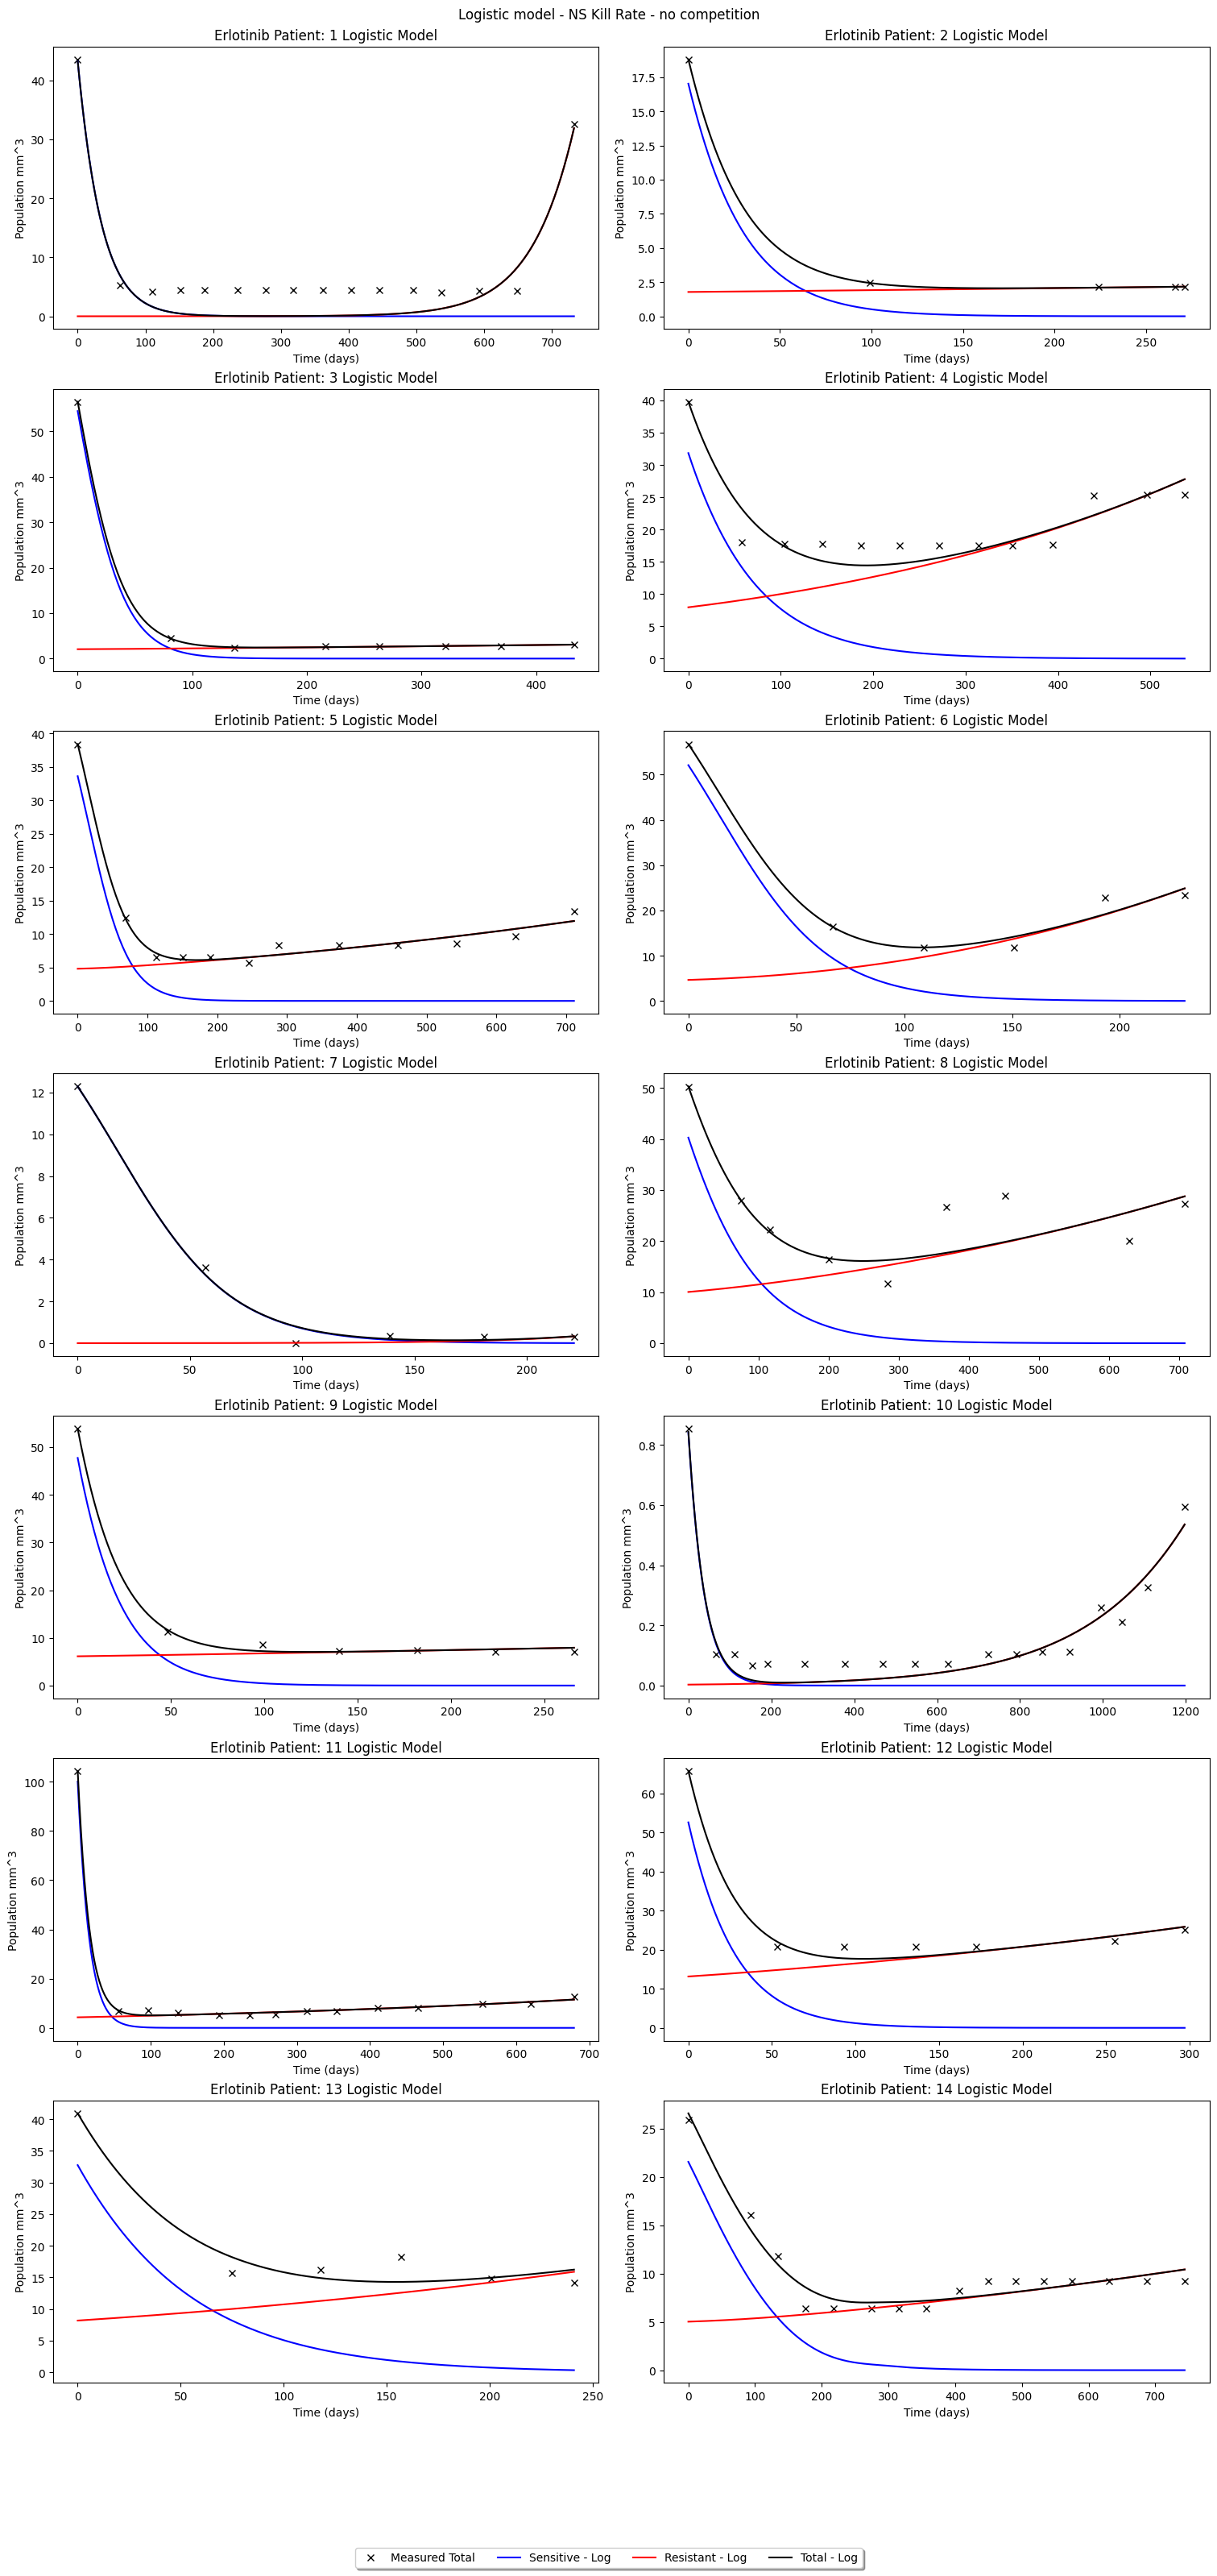

In [11]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = md_const_log_ns[id]
    init_populations_log = optimal_params_log[3:-3]
    kill_rate = 'NS'

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]+ [kill_rate]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model - NS Kill Rate - no competition')  
plt.show()

#### Gompertzian - Linear Kill rate 

In [12]:
##### basic Gompertzian, linear kill rate
#### use total tumors df
df = total_tumors_df
unique_IDs = df.ID.unique()
md_const_gomp_linear = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-5, 1e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-5, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_gompertzian, bounds, 
                                            args=(days, data, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters
    optimal_params = opt_result.x
    pred_data_log = solve_ivp(system_ode_gompertzian, [0, days[-1]], optimal_params[3:],
                              t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data_log.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_const_gomp_linear[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]


Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 5.10133
differential_evolution step 2: f(x)= 5.10133
differential_evolution step 3: f(x)= 5.03683
differential_evolution step 4: f(x)= 4.91606
differential_evolution step 5: f(x)= 4.91606
differential_evolution step 6: f(x)= 4.91606
differential_evolution step 7: f(x)= 4.73982
differential_evolution step 8: f(x)= 4.73982
differential_evolution step 9: f(x)= 4.73959
differential_evolution step 10: f(x)= 4.73959
differential_evolution step 11: f(x)= 4.60192
differential_evolution step 12: f(x)= 4.5272
differential_evolution step 13: f(x)= 4.5272
differential_evolution step 14: f(x)= 4.3487
differential_evolution step 15: f(x)= 4.3487
differential_evolution step 16: f(x)= 4.3487
differential_evolution step 17: f(x)= 4.3487
differential_evolution step 18: f(x)= 4.3487
differential_evolution step 19: f(x)= 4.3487
differential_evolution step 20: f(x)= 4.3487
differential_evolution step 21: f(x)= 4.30815

C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:12: RuntimeWarning: invalid value encountered in log
  dSpop_dt = Spop*(r* np.log(kmax/(Spop+Rpop + epsilon))+ -lam*C) # linear kill rate
C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:20: RuntimeWarning: invalid value encountered in log
  dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop


differential_evolution step 189: f(x)= 3.45099
differential_evolution step 190: f(x)= 3.45099
differential_evolution step 191: f(x)= 3.45096
differential_evolution step 192: f(x)= 3.45096
differential_evolution step 193: f(x)= 3.44912
differential_evolution step 194: f(x)= 3.44866
differential_evolution step 195: f(x)= 3.44866
differential_evolution step 196: f(x)= 3.44866
differential_evolution step 197: f(x)= 3.44858
differential_evolution step 198: f(x)= 3.44858
differential_evolution step 199: f(x)= 3.44858
differential_evolution step 200: f(x)= 3.44858
differential_evolution step 201: f(x)= 3.44803
differential_evolution step 202: f(x)= 3.44793
Polishing solution with 'L-BFGS-B'
Working on patient: A1004  Number of data points: 5
differential_evolution step 1: f(x)= 0.180523
differential_evolution step 2: f(x)= 0.180523
differential_evolution step 3: f(x)= 0.172296
differential_evolution step 4: f(x)= 0.172296
differential_evolution step 5: f(x)= 0.172296
differential_evolution st

In [13]:
df_gomp_linear_no_comp = pd.DataFrame.from_dict(md_const_gomp_linear, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0',
                                              'rmse','aic','r_squared'])

df_gomp_linear_no_comp

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared
A1002,0.007416,80.101767,0.027913,41.939247,0.000010,3.447064,49.600734,0.907050
A1004,0.000010,28.224854,0.040518,16.684836,2.131733,0.000317,-70.551426,1.000000
A1006,0.000167,376.801377,0.040597,54.359223,2.163473,0.136880,-21.818388,0.999940
A1007,0.002042,59.775096,0.015574,31.845523,7.959785,2.239526,30.962876,0.871837
A1008,0.000379,357.400926,0.024201,33.949038,4.470538,0.909697,7.728557,0.988657
A1009,0.005718,88.509538,0.030579,53.691136,3.126908,1.950464,18.016806,0.983968
A1011,0.000010,83.940912,0.025072,12.351810,0.000010,0.532342,2.434378,0.985477
A1012,0.001206,75.700028,0.012650,40.328532,10.049745,4.788960,38.193638,0.781282
A1013,0.000010,89.975710,0.050763,46.510321,7.388874,0.389631,-3.195776,0.999412
A1014,0.001254,8.534361,0.029614,0.850360,0.000187,0.052446,-96.126660,0.935729


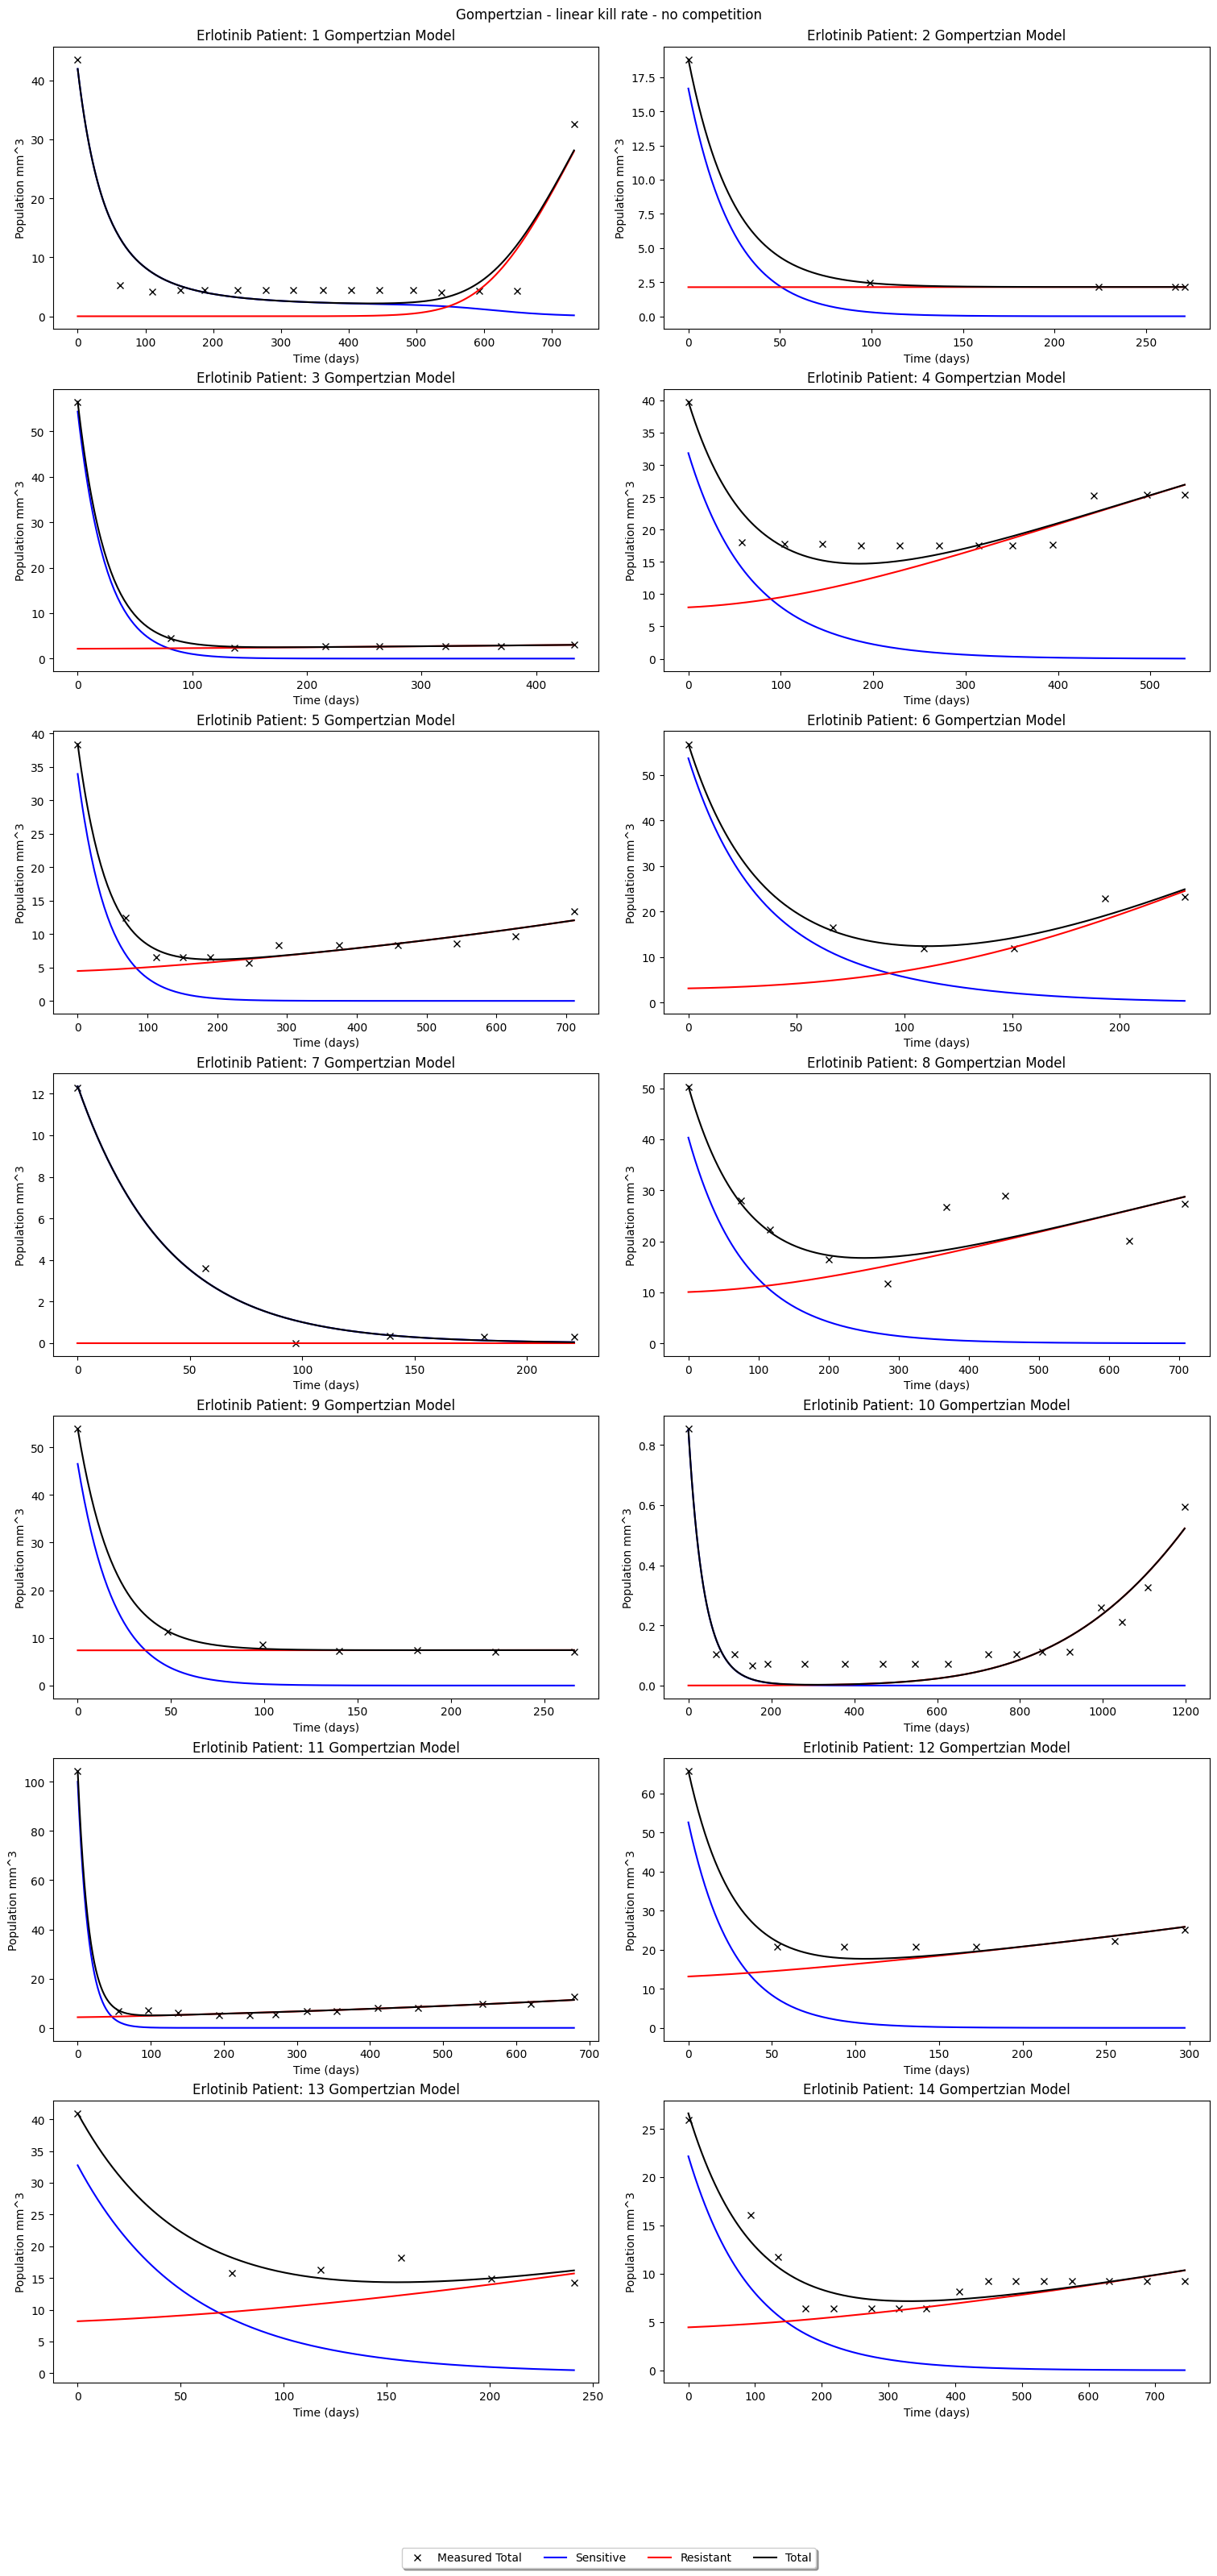

In [14]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = md_const_gomp_linear[id]
    init_populations = optimal_params[3:-3]
    kill_rate = 'linear'

    pred_data = solve_ivp(system_ode_gompertzian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]+ [kill_rate]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Gompertzian Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian - linear kill rate - no competition')  
plt.show()

#### Gompertzian NS kill rate 

In [15]:
##### basic Gompertzian, NS kill rate
#### use total tumors df
df = total_tumors_df
unique_IDs = df.ID.unique()
md_const_gomp_ns = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'NS' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-5, 1e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-5, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_gompertzian, bounds, 
                                            args=(days, data, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters
    optimal_params = opt_result.x
    pred_data_log = solve_ivp(system_ode_gompertzian, [0, days[-1]], optimal_params[3:],
                              t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data_log.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_const_log_ns[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]


Working on patient: A1002  Number of data points: 16


C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:15: RuntimeWarning: invalid value encountered in log
  dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*C)*Spop
C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:20: RuntimeWarning: invalid value encountered in log
  dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop


differential_evolution step 1: f(x)= 41.191
differential_evolution step 2: f(x)= 6.04683
differential_evolution step 3: f(x)= 6.04683
differential_evolution step 4: f(x)= 6.04683
differential_evolution step 5: f(x)= 6.04683
differential_evolution step 6: f(x)= 6.04683
differential_evolution step 7: f(x)= 6.04683
differential_evolution step 8: f(x)= 6.04683
differential_evolution step 9: f(x)= 6.04683
differential_evolution step 10: f(x)= 6.04683
differential_evolution step 11: f(x)= 5.22745
differential_evolution step 12: f(x)= 5.22745
differential_evolution step 13: f(x)= 5.22745
differential_evolution step 14: f(x)= 5.22745
differential_evolution step 15: f(x)= 5.22745
differential_evolution step 16: f(x)= 5.22745
differential_evolution step 17: f(x)= 5.22745
differential_evolution step 18: f(x)= 5.04652
differential_evolution step 19: f(x)= 4.9368
differential_evolution step 20: f(x)= 4.77953
differential_evolution step 21: f(x)= 4.72635
differential_evolution step 22: f(x)= 4.72635

In [16]:
df_gomp_ns_no_comp = pd.DataFrame.from_dict(md_const_log_ns, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_gomp_ns_no_comp

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared
A1002,0.003002,435.435644,4.107778,43.120698,0.000010,4.100655,55.156693,0.868460
A1004,0.000883,187.824357,9.994065,17.973094,0.839764,0.131034,-10.322976,0.999611
A1006,0.001026,564.878631,9.996912,56.041577,0.415561,0.951863,9.210648,0.997115
A1007,0.000770,397.601766,7.731920,31.845593,7.959874,2.635455,35.195454,0.822515
A1008,0.000636,382.012051,10.000000,34.779112,2.515299,1.655930,22.104708,0.962415
A1009,0.004340,96.840480,6.270818,51.799514,4.911920,1.804320,17.082203,0.986280
A1011,0.002815,18.436751,9.870934,12.283011,0.045989,0.161747,-11.860699,0.998659
A1012,0.000489,472.363899,9.991153,40.217133,10.026276,4.886767,38.557557,0.772257
A1013,0.001246,538.597786,10.000000,50.922165,2.489895,2.160499,20.784750,0.981906
A1014,0.001217,8.492039,8.456052,0.845873,0.000159,0.055876,-93.846131,0.927048


C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:15: RuntimeWarning: invalid value encountered in log
  dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*C)*Spop
C:\Users\lstocker\AppData\Local\Temp\ipykernel_13660\3722228194.py:20: RuntimeWarning: invalid value encountered in log
  dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop


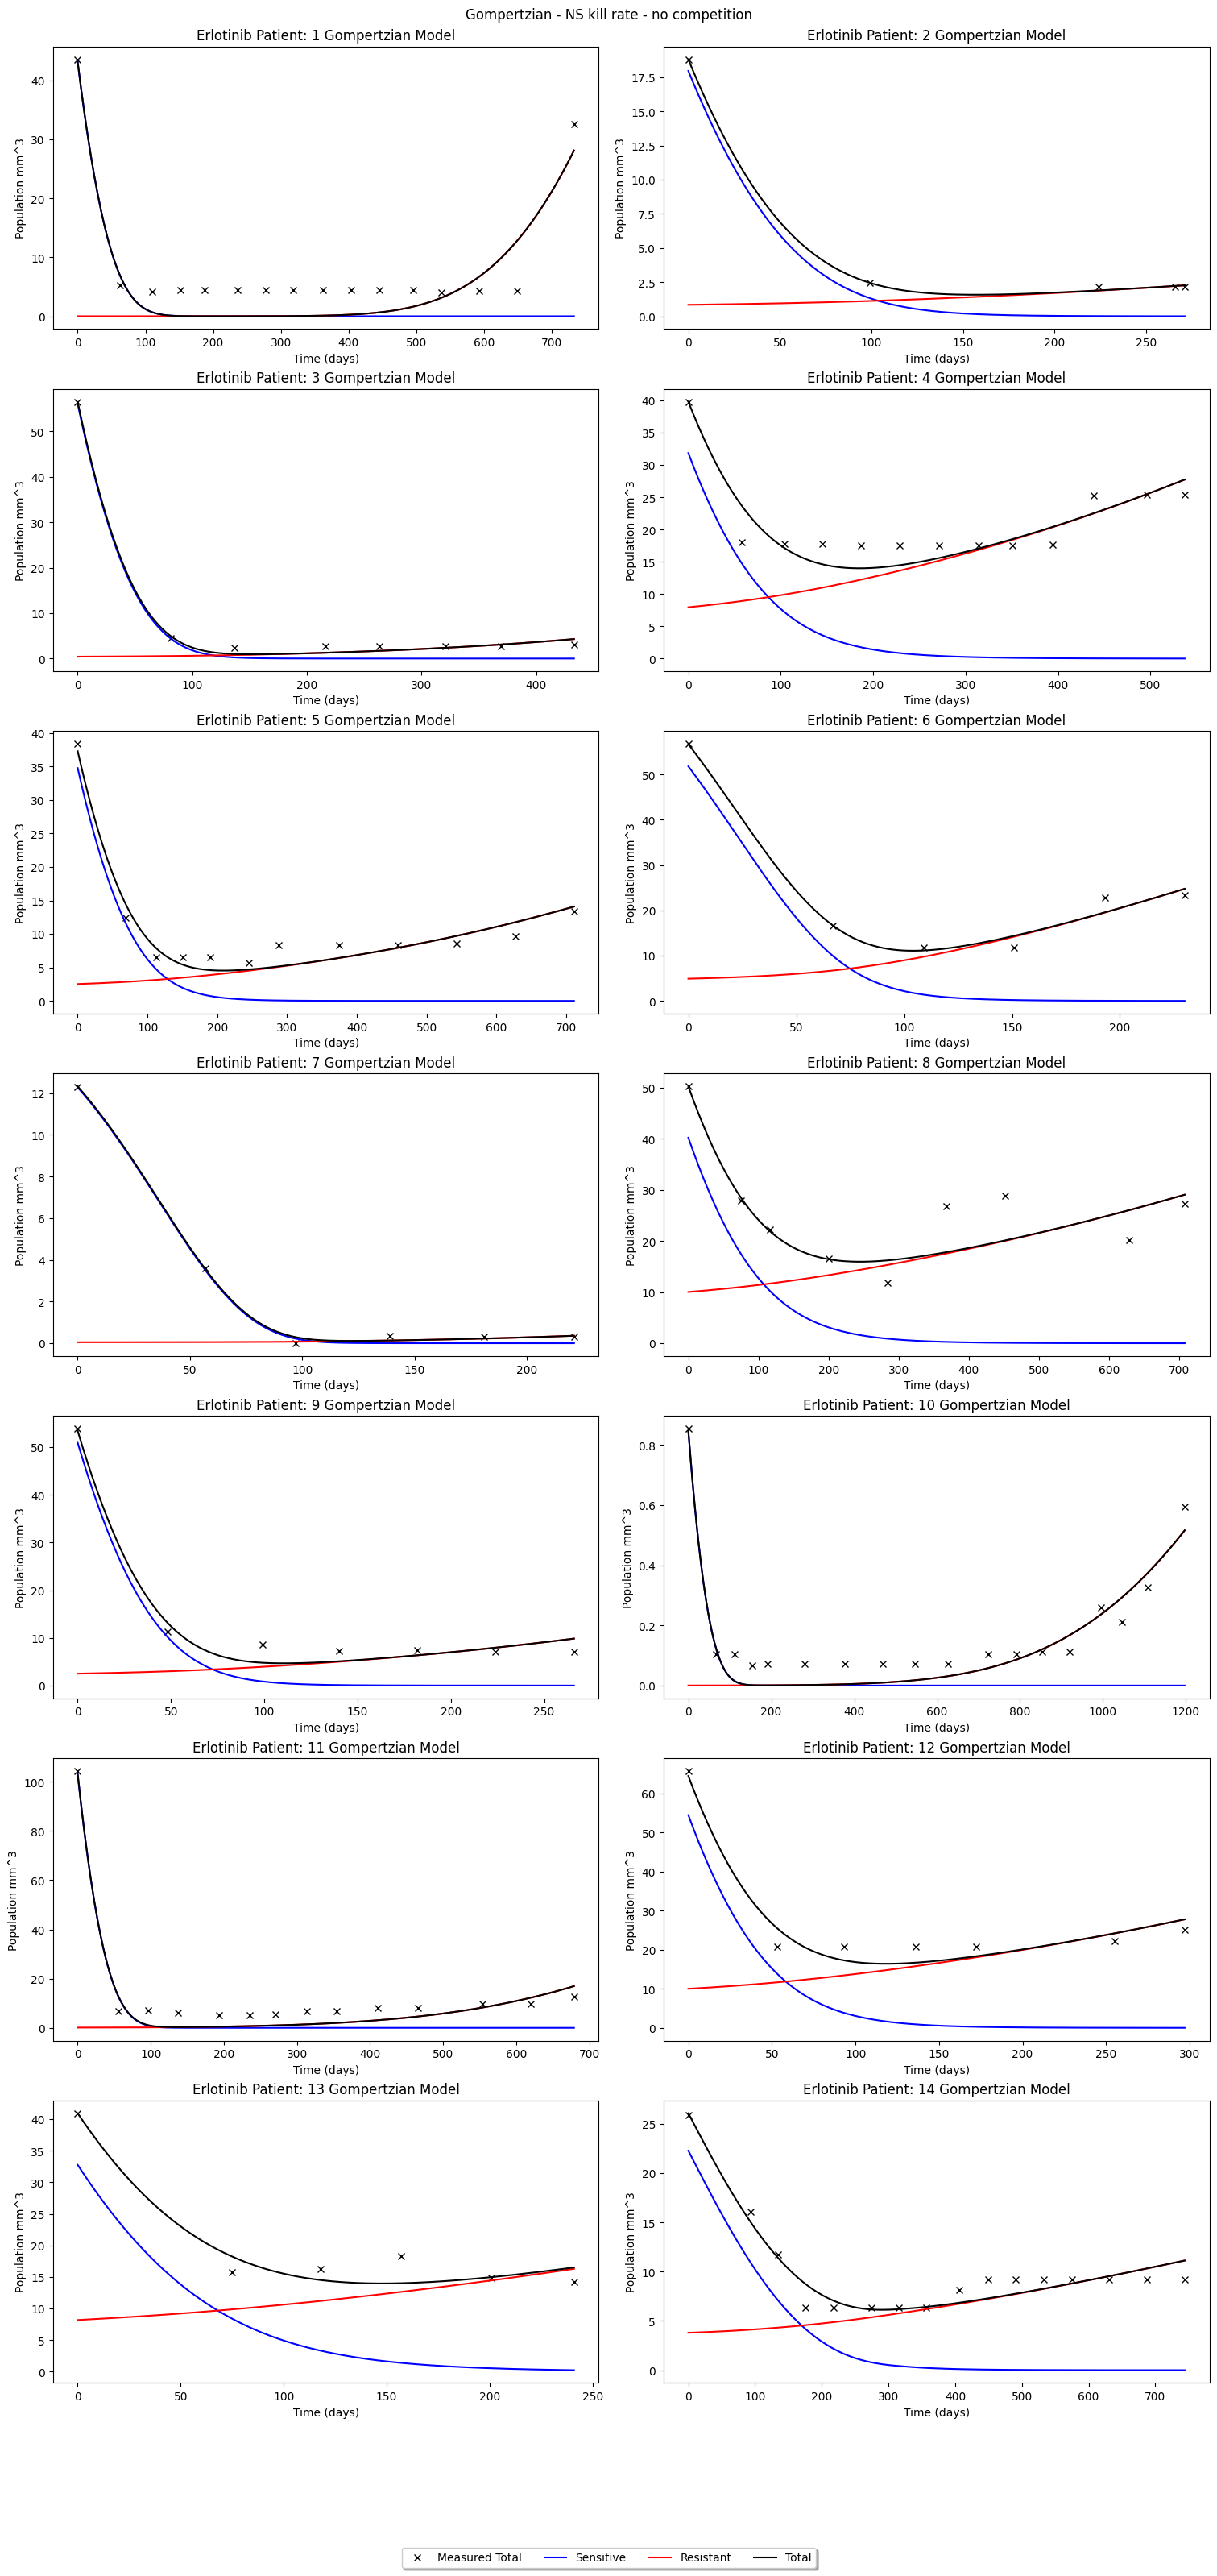

In [17]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = md_const_log_ns[id]
    init_populations = optimal_params[3:-3]
    kill_rate = 'NS'# linear or NS

    pred_data = solve_ivp(system_ode_gompertzian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]+ [kill_rate]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive') # plot gompertzian model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Gompertzian Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian - NS kill rate - no competition')  
plt.show()

#### Von Bertalanffy no comp, linear kill rate 

In [18]:
# ##### basic vbf, linear kill rate
# #### use total tumors df
# df = total_tumors_df
# unique_IDs = df.ID.unique()
# md_vB_const_linear = {} # dictionary to store the optimized parameters for each patient 

# # Find optimal parameters for each patient
# for id in unique_IDs:
#     days = df.days[df.ID == id].tolist()
#     data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
#     max_value = max(data[0], data[-1])
#     kill_rate = 'linear' # linear or NS 

#     print("Working on patient:", id, " Number of data points:", len(days))
#     if kill_rate == 'linear':
#         bounds = [(1e-5, 1e-2), (0,1), # r,a
#                   (0,10),(0,10),# Beta, lambda
#                   (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0, rpop0
#     elif kill_rate == 'linear':   
#         bounds = [(5e-1, 5e-1), (1.5*max_value, 10*max_value), # r,a
#                   (0.1,10),(0,1),   # Beta, lambda
#                   (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0,rpop0

#     # Use differential_evolution to perform a random search
#     opt_result = differential_evolution(cost_func_vb, bounds, 
#                                             args=(days, data, kill_rate),
#                                              maxiter=1000, popsize=100, disp=True)
#     # store the optimal parameters and the cost function value (last entry in list)
#     md_vB_const_linear[id] = opt_result.x.tolist() + [opt_result.fun]

In [19]:
# df_vb_linear_no_comp = pd.DataFrame.from_dict(md_vB_const_linear, orient='index', 
#                                      columns=['r','a','Beta','lambda','spop_0','rpop_0','error'])

# df_vb_linear_no_comp

In [20]:
# # setting up subplots   
# n = len(unique_IDs)
# ncols = 2
# nrows = np.ceil(n / ncols).astype(int)
# fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# # fitting data 
# for index, id in enumerate(unique_IDs, start=0):
#     #print("Patient:", id, " Optimal parameters: ", md_vB_const_linear[id])
#     days = df.days[df.ID == id].tolist()
#     data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
#     tspan = np.linspace(0, days[-1], 300)

#     optimal_params = md_vB_const_linear[id]
#     init_populations = optimal_params[4:-1]
#     kill_rate = 'linear'

#     pred_data = solve_ivp(system_ode_vonBertalanffy, [0,days[-1]],
#                             init_populations, dense_output=True,
#                             args = tuple([optimal_params[:4]] + [kill_rate]))
#     sum_pops = np.sum(pred_data.sol(tspan), axis=0)

# #plotting 
#     ax = axs.flatten()[(index)%len(unique_IDs)]  

#     ax.plot(days, data, 'kx', label='Measured Total') # plot data points
#     ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive') # plot logistic model
#     ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant') 
#     ax.plot(tspan, sum_pops, 'k-', label='Total')
#     ax.set_xlabel('Time (days)')
#     ax.set_ylabel('Population mm^3')
#     ax.set_title(f'Erlotinib Patient: {index +1} von Bertalanffy Model') 

# for i in range(index+1, nrows*ncols):
#     axs.flatten()[i].axis('off') #hide empty subplots

# legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
#                    Line2D([0], [0], color='b', label='Sensitive'),
#                    Line2D([0], [0], color='r', label='Resistant'),
#                    Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]
          
# fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
# fancybox=True, shadow=True, ncol=7)
# fig.suptitle('von Bertalanffy - linear kill rate - no competition')  
# plt.show()

#### von Bertalanffy - NS kill

In [21]:
# ##### basic vbf, NS rate
# #### use total tumors df
# df = total_tumors_df
# unique_IDs = df.ID.unique()
# md_vB_const_ns = {} # dictionary to store the optimized parameters for each patient 

# # Find optimal parameters for each patient
# for id in unique_IDs:
#     days = df.days[df.ID == id].tolist()
#     data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
#     max_value = max(data[0], data[-1])
#     kill_rate = 'NS' # linear or NS 

#     print("Working on patient:", id, " Number of data points:", len(days))
#     if kill_rate == 'linear':
#         bounds = [(1e-5, 1e-2), (0,1), # r,a
#                   (0,10),(0,10),# Beta, lambda
#                   (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0, rpop0
#     elif kill_rate == 'NS':   
#         bounds = [(5e-5, 5e-1), (0,1), # r,a
#                   (0.1,10),(0,1),   # Beta, lambda
#                   (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0,rpop0

#     # Use differential_evolution to perform a random search
#     opt_result = differential_evolution(cost_func_vb, bounds, 
#                                             args=(days, data, kill_rate),
#                                              maxiter=1000, popsize=100, disp=True)
#     # store the optimal parameters and the cost function value (last entry in list)
#     md_vB_const_ns[id] = opt_result.x.tolist() + [opt_result.fun]

In [22]:
# df_vb_ns_no_comp = pd.DataFrame.from_dict(md_vB_const_ns, orient='index', 
#                                      columns=['r','a','Beta','lambda','spop_0','rpop_0','error'])

# df_vb_ns_no_comp

## With medication vector 


##### functions

In [23]:

# # Logistic population model
def system_ode_logistic(time, populations, params, C, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #death rate due to medication
    epsilon = 1e-6

  # Find the appropriate value of C for the current time
    index = np.searchsorted(C[:, 0], time) - 1
    if index < 0:
        index = 0
    C_current = C[index, 1]

    if kill_rate == 'linear':
        dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - lam*C) # linear kill rate
    elif kill_rate == 'NS':
        dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax))*(1-lam*C) # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")

    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function for logistic population model
def cost_func_logistic(params, time, data, C, kill_rate='linear'):
    initial_populations = params[3:]
    tspan = [time[0], time[-1]]

    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:3], C, kill_rate))

    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return [rmse]
    #return huber_loss
   

In [24]:
#### gompertzian model with medication 

def system_ode_gompertzian(time, populations, params, C, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #death rate due to medication
    epsilon = 1e-6

  # Find the appropriate value of C for the current time
    index = np.searchsorted(C[:, 0], time) - 1
    if index < 0:
        index = 0
    C_current = C[index, 1]

    if kill_rate == 'linear':
        dSpop_dt = Spop*(r* np.log(kmax/(Spop+Rpop + epsilon))+ -lam*C) # linear kill rate 
 # linear kill rate
    elif kill_rate == 'NS':
            dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*C)*Spop 
 # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")

    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function for gompertzian population model
def cost_func_gompertzian(params, time, data, C, kill_rate='linear'):
    initial_populations = params[4:]
    tspan = [time[0], time[-1]]

    pred_data_log = solve_ivp(system_ode_gompertzian, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:3], C, kill_rate))

    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   

##### logistic basic linear with medication

In [25]:
# ##### basic logistic, linear kill rate
# #### use total tumors df
df = total_tumors_df
#df = df[df['ID'] == 'A1006'] test with one patient
C = np.array(df[['days', 'dose_proportion']])
unique_IDs = df.ID.unique()
md_log_linear_med = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    # Get the rows for the current patient
    df_id = df[df.ID == id]
    data = df_id.Sum_tumor_vol_cm.tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    # Create the C array for the current patient
    C_id = np.array(df_id[['days', 'dose_proportion']])
    days = df_id.days.tolist()


    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-5, 1e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-1, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, C_id, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters to find AIC and R-squared
    optimal_params = opt_result.x
    pred_data = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
                          t_eval=days, args=(optimal_params[:3], C_id, kill_rate))
    # pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
    #                           t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_log_linear_med[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]

Working on patient: A1002  Number of data points: 16


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
df_log_linear_med_no_comp = pd.DataFrame.from_dict(md_log_linear_med, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_log_linear_med_no_comp 

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared


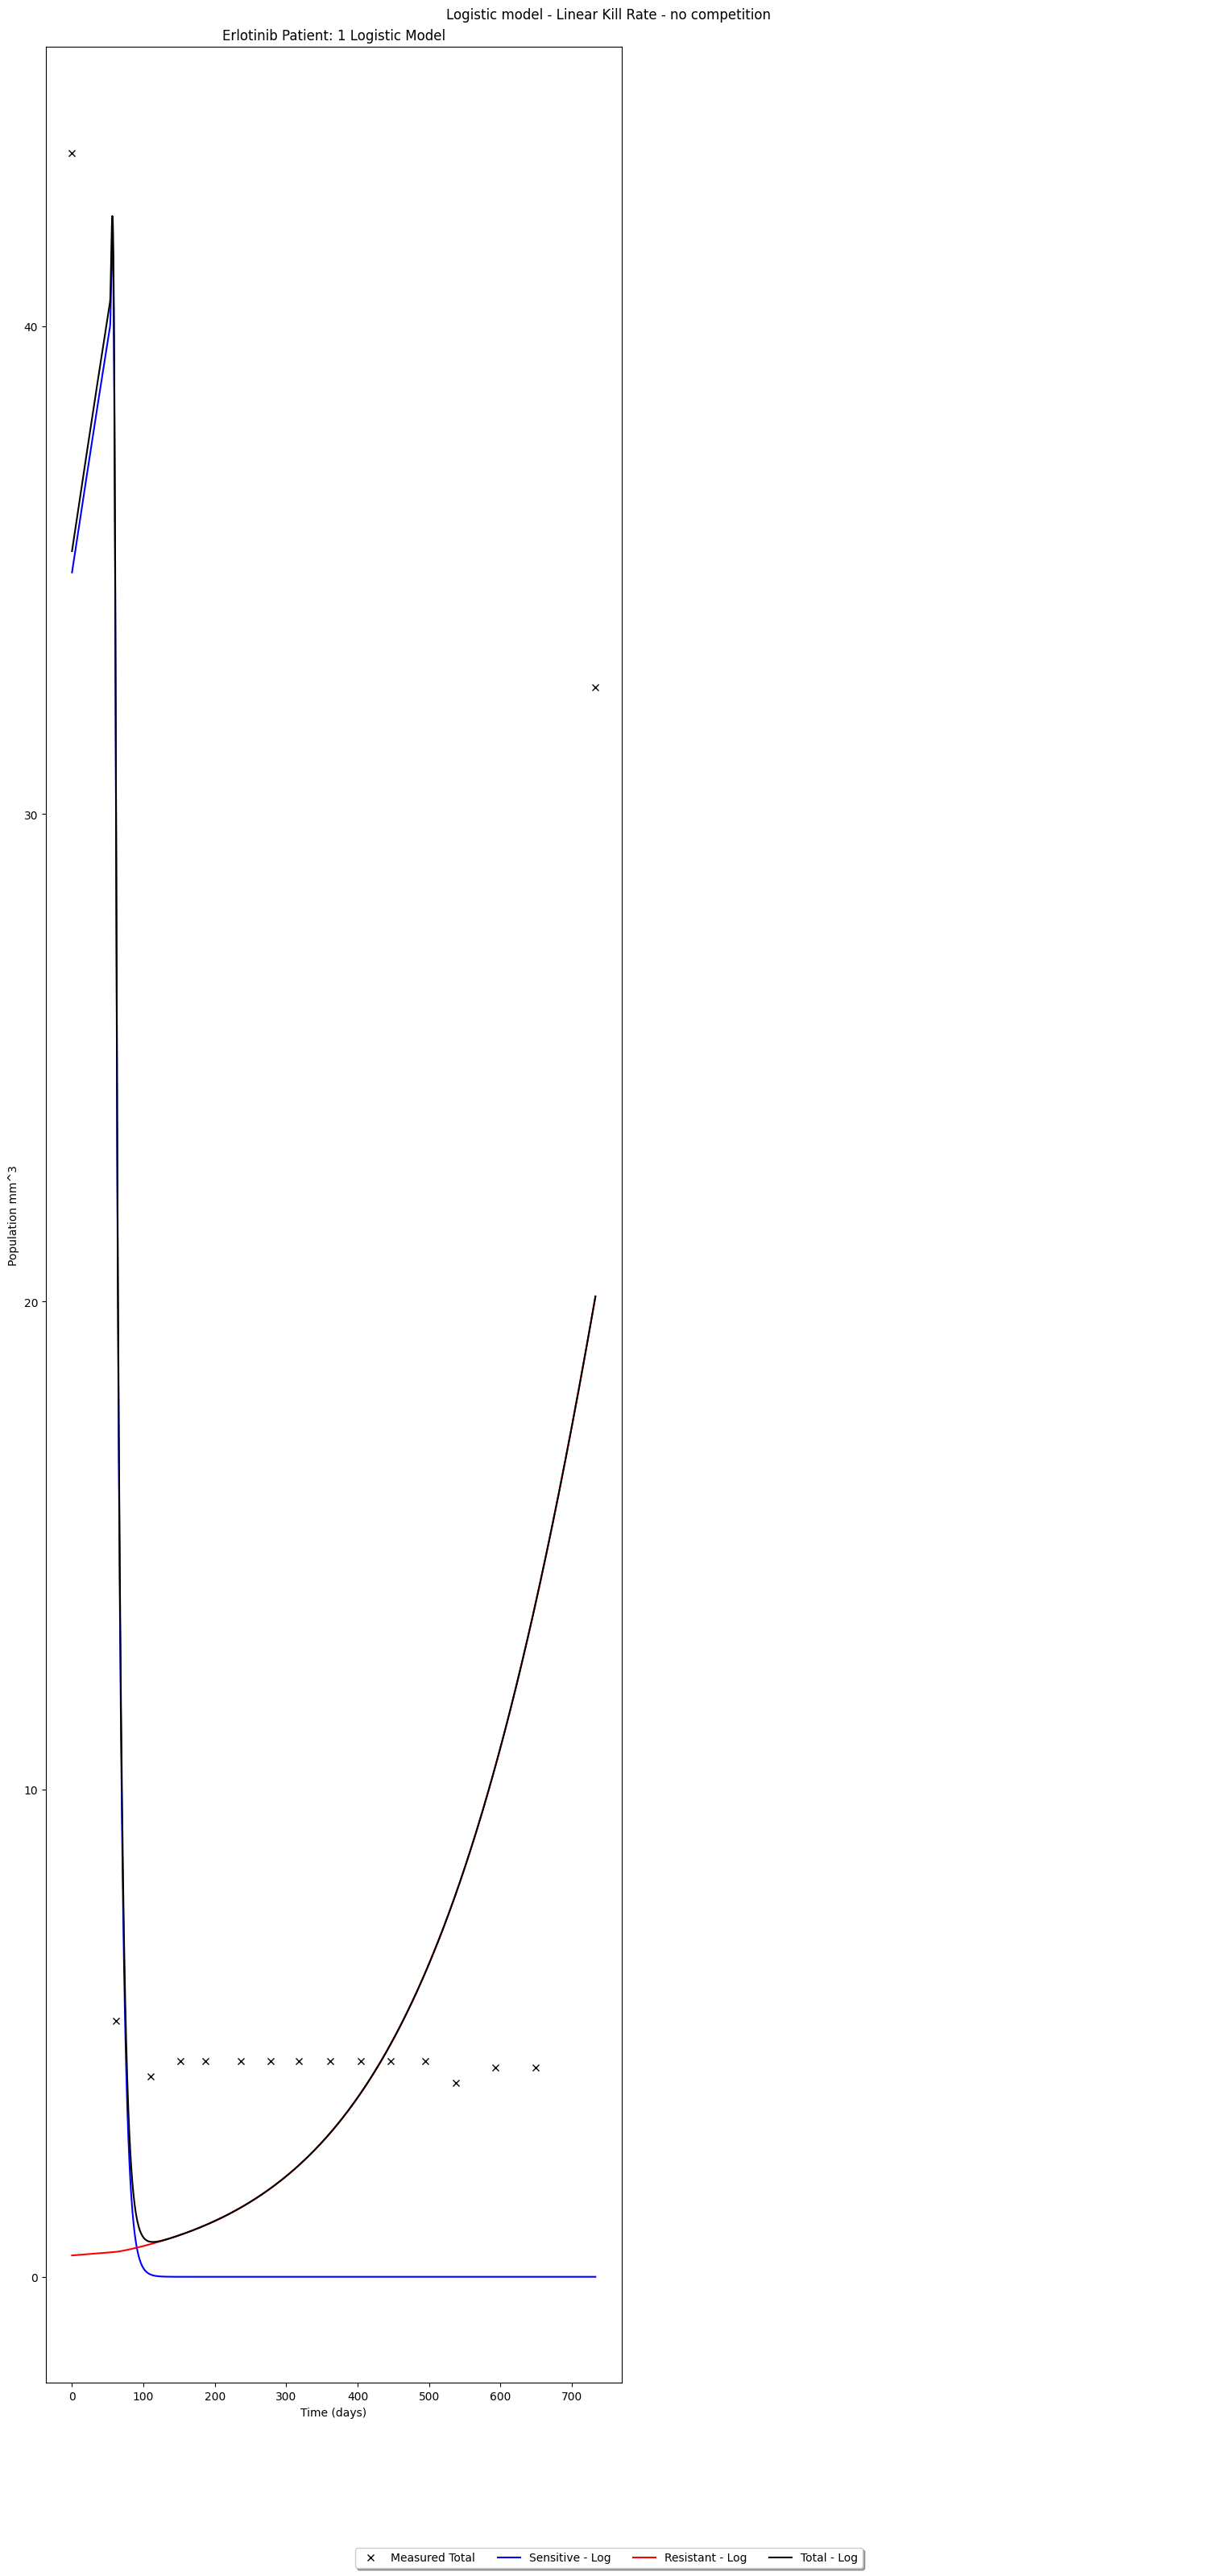

In [ ]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    C_id = C[df.ID == id]  # Get the C vector for the current patient
    tspan = np.linspace(0, days[-1], 2000)

    optimal_params_log = md_log_linear_med[id]
    init_populations_log = optimal_params_log[3:-3]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]] + [C_id]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model - Linear Kill Rate - no competition')  
plt.show()

##### without 1st point - logistic, linear kill 

In [ ]:
df = total_tumors_df.groupby('ID').apply(lambda x: x.iloc[1:]).reset_index(drop=True) # remove first data point
df['days'] = no_first_point_df.groupby('ID')['days'].transform(lambda x: x - x.min()) # reset days to start at 0
df = df[df['ID'] != 'A1004'] # not enough data points with first point gone
C = np.array(df[['days', 'dose_proportion']])
unique_IDs = df.ID.unique()
md_log_linear_med_no1 = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    # Get the rows for the current patient
    df_id = df[df.ID == id]

    # Create the C array for the current patient
    C_id = np.array(df_id[['days', 'dose_proportion']])

    days = df_id.days.tolist()
    data = df_id.Sum_tumor_vol_cm.tolist()

    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-4, 5e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-1, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, C_id, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters to find AIC and R-squared
    optimal_params = opt_result.x
    pred_data = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
                          t_eval=days, args=(optimal_params[:3], C_id, kill_rate))
    # pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
    #                           t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_log_linear_med_no1[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]

Working on patient: A1002  Number of data points: 15
differential_evolution step 1: f(x)= 4.09075
differential_evolution step 2: f(x)= 3.7827
differential_evolution step 3: f(x)= 3.66476
differential_evolution step 4: f(x)= 3.66476
differential_evolution step 5: f(x)= 3.66476
differential_evolution step 6: f(x)= 3.33762
differential_evolution step 7: f(x)= 3.33762
differential_evolution step 8: f(x)= 3.33762
differential_evolution step 9: f(x)= 3.33762
differential_evolution step 10: f(x)= 3.33762
differential_evolution step 11: f(x)= 3.33762
differential_evolution step 12: f(x)= 3.19994
differential_evolution step 13: f(x)= 3.19994
differential_evolution step 14: f(x)= 3.19994
differential_evolution step 15: f(x)= 2.88501
differential_evolution step 16: f(x)= 2.6127
differential_evolution step 17: f(x)= 2.6127
differential_evolution step 18: f(x)= 2.6127
differential_evolution step 19: f(x)= 2.6127
differential_evolution step 20: f(x)= 2.6127
differential_evolution step 21: f(x)= 2.61

In [ ]:
df_log_linear_med_no_comp_no1st = pd.DataFrame.from_dict(md_log_linear_med_no1, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_log_linear_med_no_comp_no1st 

,r,Kmax,kd,spop_0,rpop_0,rmse,aic,r_squared
A1002,0.005420,65.719501,0.157815,34.889897,0.625279,7.863863,75.992895,0.516248
A1004,0.000067,65.858147,0.105514,15.056973,0.431312,4.232662,24.428311,0.593700
A1006,0.000043,385.541915,0.184916,45.251821,0.152970,10.491123,47.608472,0.649520
A1007,0.002504,376.098202,0.062091,31.842278,7.959706,5.536956,54.497566,0.216585
A1008,0.002194,59.596650,0.051207,30.725861,3.466609,4.344274,45.252605,0.741320
A1009,0.007073,85.492382,0.049190,45.387108,6.195937,11.220795,39.013225,0.469396
A1011,0.000143,109.409723,0.101639,9.974502,0.009423,1.647832,15.993523,0.860842
A1012,0.002202,75.478169,0.065201,40.210453,10.008416,6.730707,44.320244,0.567961
A1013,0.000576,80.857129,0.030657,43.110034,3.384964,8.912562,40.624464,0.692088
A1014,0.003499,1.282168,0.197172,0.684942,0.010947,0.122984,-65.445252,0.646588


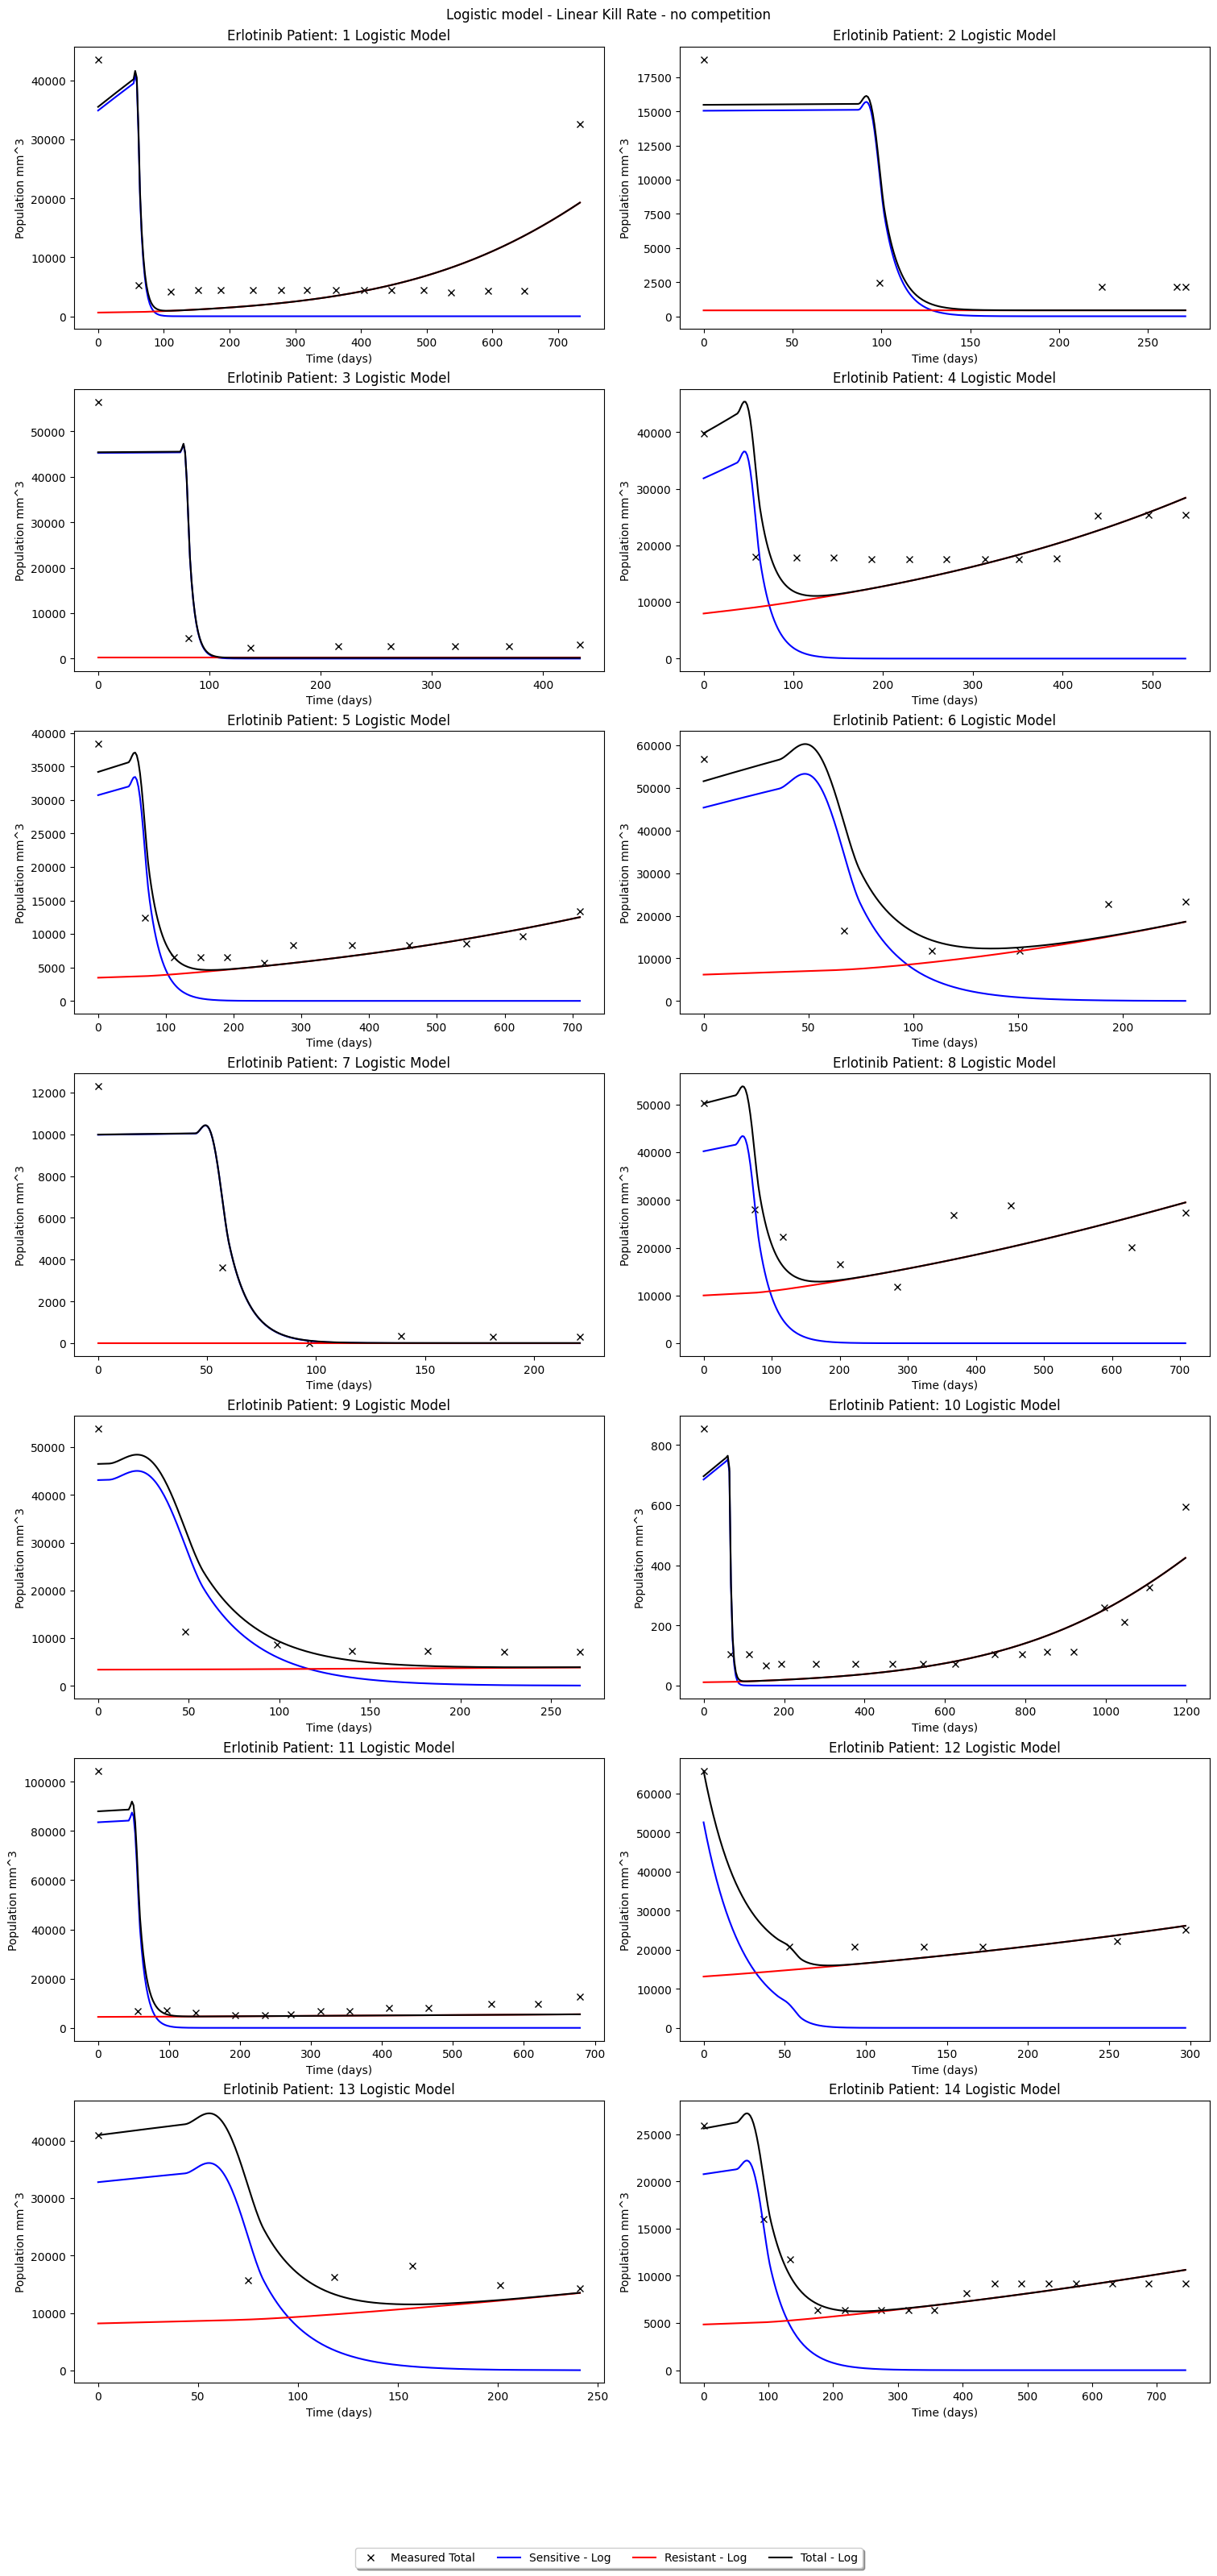

In [ ]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    C_id = C[df.ID == id]  # Get the C vector for the current patient
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = md_log_linear_med_no1[id]
    init_populations_log = optimal_params_log[3:5]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]] + [C_id]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 
    formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    ax.yaxis.set_major_formatter(formatter) ### return to mm^3

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model - Linear Kill Rate - no competition')  
plt.show()

#### Gompertzian with medication 

##### Linear 

In [ ]:
# Gompertzian, linear kill rate , medication
# #### use total tumors df
df = total_tumors_df
#df = df[df['ID'] == 'A1006'] test with one patient
C = np.array(df[['days', 'dose_proportion']])
unique_IDs = df.ID.unique()
md_gomp_linear_med = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    # Get the rows for the current patient
    df_id = df[df.ID == id]
    data = df_id.Sum_tumor_vol_cm.tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    # Create the C array for the current patient
    C_id = np.array(df_id[['days', 'dose_proportion']])
    days = df_id.days.tolist()
    
    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-5, 1e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-5, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_gompertzian, bounds, 
                                            args=(days, data, C_id, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters to find AIC and R-squared
    optimal_params = opt_result.x
    pred_data = solve_ivp(system_ode_gompertzian, [0, days[-1]], optimal_params[3:],
                          t_eval=days, args=(optimal_params[:3], C_id, kill_rate))
    # pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[3:],
    #                           t_eval=days, args=(optimal_params[:3], kill_rate))
    sum_pops = np.sum(pred_data.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_gomp_linear_med[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]

In [ ]:
df_gomp_linear_med = pd.DataFrame.from_dict(md_gomp_linear_med, orient='index', 
                                        columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_gomp_linear_med

##### NS 

## With 2 growth rates

#### Functions with medication vector 

In [ ]:

# # Logistic population model with 2 growth rates and medication
def system_ode_logistic(time, populations, params, C, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r1 = params[0] #growth rate sensitive
    r2 = params[1] #growth rate resistant
    kmax = params[2] #carrying capacity
    lam = params[3] #death rate due to medication
    epsilon = 1e-6

  # Find the appropriate value of C for the current time
    index = np.searchsorted(C[:, 0], time) - 1
    if index < 0:
        index = 0
    C_current = C[index, 1]

    if kill_rate == 'linear':
        dSpop_dt = Spop * (r1 * (1- (Spop + Rpop)/kmax) - lam*C) # linear kill rate
    elif kill_rate == 'NS':
        dSpop_dt = Spop * (r1 * (1- (Spop + Rpop)/kmax))*(1-lam*C) # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")

    dRpop_dt = Rpop * (r2 * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function for logistic population model
def cost_func_logistic(params, time, data, C, kill_rate='linear'):
    initial_populations = params[4:]
    tspan = [time[0], time[-1]]

    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:4], C, kill_rate))

    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   

#### Logistic Linear 

In [ ]:
# ##### basic logistic, linear kill rate
# #### use total tumors df
df = total_tumors_df
#df = df[df['ID'] == 'A1006'] test with one patient
C = np.array(df[['days', 'dose_proportion']])
unique_IDs = df.ID.unique()
md_log_linear_2r = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    # Get the rows for the current patient
    df_id = df[df.ID == id]
    data = df_id.Sum_tumor_vol_cm.tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    # Create the C array for the current patient
    C_id = np.array(df_id[['days', 'dose_proportion']])
    days = df_id.days.tolist()


    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-5, 1e-2), (1.5*max_value, 10*max_value), 
                  (5e-3, 2e-1),(0.8*data[0], 1.1*data[0]),(1e-5,0.2*data[0])] # r, K, kd, spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-1, 5e-1), (1.5*max_value, 10*max_value), 
                  (0.1,10),(0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # r, K, kd, spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, C_id, kill_rate),
                                             maxiter=1000, popsize=100, disp=True)
    
    # Calculate the predictions using the optimal parameters to find AIC and R-squared
    optimal_params = opt_result.x
    pred_data = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[4:],
                          t_eval=days, args=(optimal_params[:4], C_id, kill_rate))

    sum_pops = np.sum(pred_data.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_log_linear_2r[id] = optimal_params.tolist() + [opt_result.fun, aic, r_squared]

Working on patient: A1002  Number of data points: 16


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
df_log_linear_med_2r = pd.DataFrame.from_dict(md_log_linear_2r, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','rmse','aic','r_squared'])

df_log_linear_med_2r 

In [ ]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    C_id = C[df.ID == id]  # Get the C vector for the current patient
    tspan = np.linspace(0, days[-1], 2000)

    optimal_params_log = md_log_linear_2r[id]
    init_populations_log = optimal_params_log[4:-3]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:4]] + [C_id]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model - Linear Kill Rate - no competition')  
plt.show()

#### Logistic Norton-Simon 

#### Gompertz Linear

#### Gompertz Norton-Simon kill rate